In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd 
import os

In [19]:

styles_df = pd.read_csv('image_filenames.csv', on_bad_lines='skip')
print(styles_df.head())

   product_id filename
0           1    1.jpg
1           2    2.jpg
2           8    8.jpg
3           7    7.jpg
4           5    5.jpg


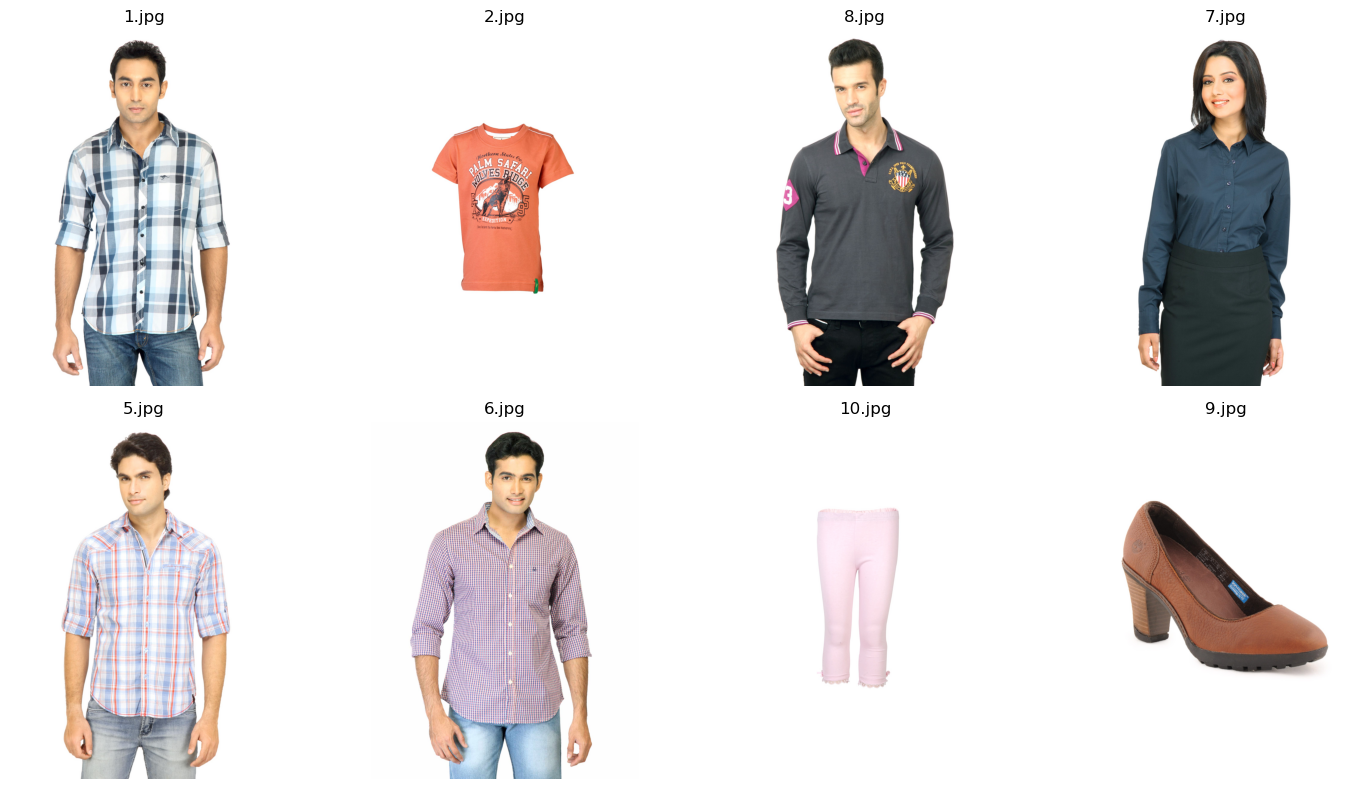

Image None not found.
Image None not found.


[ WARN:0@2401.769] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity
[ WARN:0@2401.858] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity


Image None not found.


[ WARN:0@2460.470] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity


Image None not found.


[ WARN:0@2578.865] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity


Image None not found.


[ WARN:0@2584.921] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity


Image None not found.


[ WARN:0@2608.131] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity


Image None not found.


[ WARN:0@2623.947] global loadsave.cpp:248 findDecoder imread_('product_images/failed'): can't open/read file: check file path/integrity


In [20]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

def plot_figures(figures, nrows=1, ncols=1, figsize=(8, 8)):
    if len(figures) == 0:
        print("No images to display.")
        return
    
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() 

def img_path(img):
    return "product_images/" + img 

def load_image(img, resized_fac=0.1):
    img = cv2.imread(img_path(img))
    if img is not None:
        h, w, _ = img.shape
        resized = cv2.resize(img, (int(w * resized_fac), int(h * resized_fac)), interpolation=cv2.INTER_AREA)
        return resized
    else:
        print(f"Image {img} not found.")
        return None


figures = {}
for index, row in styles_df.head(8).iterrows():  
    filename = row['filename']
    image = load_image(filename, resized_fac=1) 
    if image is not None:
        figures[filename] = image

if len(figures) > 0:
    plot_figures(figures, nrows=2, ncols=4, figsize=(15, 8))
    plt.show()
else:
    print("No valid images to display.")

for index, row in styles_df.iloc[8:].iterrows(): 
    filename = row['filename']
    image = load_image(filename)

In [19]:
%pip install faiss-cpu
%pip install numpy
%pip install tensorflow
%pip install pillow
%pip install pandas
%pip install sqlite3


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install nest_asyncio
%pip install aiosqlite

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:

#vì chạy ở đây thì nó print ra thông báo của 17k file nên không load lại được file ipynb nhé.
# t viết xử lý bất đồng bộ đoạn train này vào file async_product.py ấy 
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import faiss
import aiosqlite
import os
import pandas as pd
import asyncio
import logging


logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

img_width, img_height, _ = 224, 224, 3

# Pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D()
])

# Hàm lấy embedding của ảnh
def get_embedding(model, img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

# Hàm lưu embedding vào SQLite
async def insert_embedding(image_id, image_name, embedding, faiss_id, db_conn):
    try:
        await db_conn.execute("INSERT INTO embeddings (image_id, image_name, embedding, faiss_id) VALUES (?, ?, ?, ?)", 
                              (image_id, image_name, embedding.tobytes(), faiss_id))
        await db_conn.commit()
    except Exception as e:
        logging.error(f"Failed to insert embedding for image {image_name}: {e}")

# Hàm bất đồng bộ để xử lý ảnh
async def process_image(row, model, index, db_conn, image_folder):
    img_id = row['product_id']
    img_name = row['filename']
    img_path = os.path.join(image_folder, img_name)
    
    if not os.path.exists(img_path):
        logging.warning(f"File {img_name} does not exist, skipping...")
        return
    
    try:
        embedding = get_embedding(model, img_path)
    except Exception as e:
        logging.error(f"Failed to get embedding for image {img_name}: {e}")
        return
    
    # Thêm embedding vào FAISS index nhé 
    faiss_id = index.ntotal
    index.add(np.array([embedding], dtype=np.float32))
    
    # Lưu thông tin meta và embedding vào SQLite để tìm kiếm :))
    await insert_embedding(img_id, img_name, embedding, faiss_id, db_conn)

# Hàm chính
async def main():
    # Kết nối SQLite 
    async with aiosqlite.connect('image_embeddings.db') as db_conn:
        await db_conn.execute('''
            CREATE TABLE IF NOT EXISTS embeddings (
                id INTEGER PRIMARY KEY,
                image_id TEXT,
                image_name TEXT,
                embedding BLOB,
                faiss_id INTEGER
            )
        ''')
        await db_conn.commit()

        d = 2048  # Kích thước của embedding từ ResNet50 với GlobalMaxPooling2D
        index = faiss.IndexFlatL2(d)
        
        image_folder = 'product_images'

        image_filenames = pd.read_csv('image_filenames.csv')

        tasks = [process_image(row, model, index, db_conn, image_folder) for _, row in image_filenames.iterrows()]
        await asyncio.gather(*tasks)

        # lưu faiss và model để tí nữa cho vào web :))
        faiss.write_index(index, 'faiss_index.bin')

        model.save('embedding_model.h5')

await main()


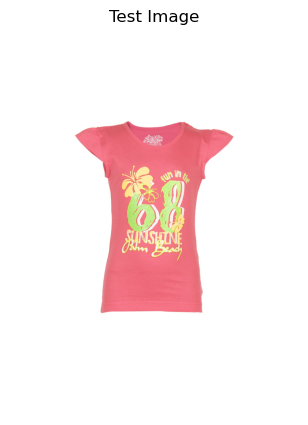

2024-05-17 20:20:05,965 - WARNING - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


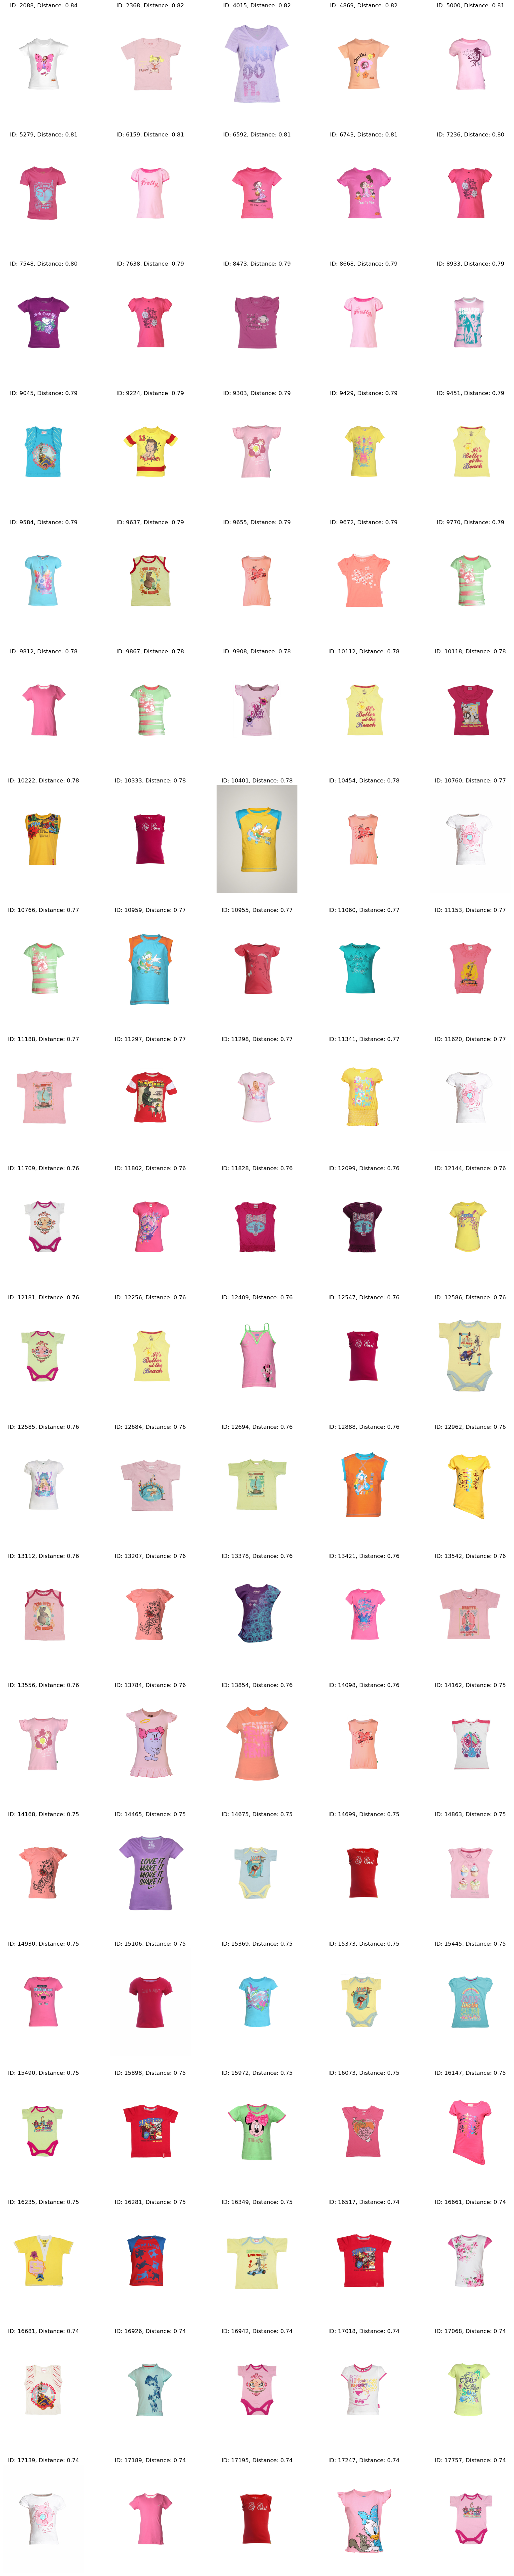

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import faiss
import aiosqlite
import os
import matplotlib.pyplot as plt
from PIL import Image
import asyncio
import logging

# Thiết lập logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(asctime)s - %(message)s')

# cho ảnh về định dạng chung khi mình train 
img_width, img_height, _ = 224, 224, 3

# Hàm để lấy embedding của ảnh
def get_embedding(model, img_path):
    try:
        img = image.load_img(img_path, target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        embedding = model.predict(x).reshape(-1)
        return embedding
    except Exception as e:
        logging.error(f"Error processing image {img_path}: {e}")
        return None

# Hàm để chuẩn hóa embedding
def normalize_embedding(embedding):
    norm = np.linalg.norm(embedding)
    return embedding / norm

# Hàm để tìm các hình ảnh giống nhất
async def find_similar_images(model, index, conn, img_path, top_k=100):
    embedding = get_embedding(model, img_path)
    if embedding is None:
        return []

    normalized_embedding = normalize_embedding(embedding)
    D, I = index.search(np.array([normalized_embedding], dtype=np.float32), top_k)
    
    similar_images = []
    async with conn.execute("SELECT image_id, image_name FROM embeddings WHERE faiss_id IN ({})".format(','.join(['?']*len(I[0]))), I[0].tolist()) as cursor:
        async for row in cursor:
            similar_images.append((row[0], row[1]))
    
    return similar_images, D[0]

# Hàm để hiển thị các ảnh
def display_images(image_paths, titles=None):
    if len(image_paths) == 0:
        print("No images to display.")
        return
    
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Chuyển đổi mảng 2D thành 1D để dễ dàng xử lý
    
    for img_path, title, ax in zip(image_paths, titles, axes):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    for ax in axes[len(image_paths):]:
        fig.delaxes(ax)  

    plt.show()

# Hàm chính để tìm và hiển thị các ảnh tương đồng ở đây t tìm 100 files 
async def main(test_img_path, top_k=100):
    # Tải lại FAISS index
    index = faiss.read_index('faiss_index.bin')

    # Tải lại mô hình đã lưu
    model = load_model('embedding_model.h5')

    async with aiosqlite.connect('image_embeddings.db') as conn:
        similar_images, distances = await find_similar_images(model, index, conn, test_img_path, top_k)

        if similar_images:
            image_paths = []
            titles = []
            for (image_id, image_name), distance in zip(similar_images, distances):
                img_path = os.path.join('product_images', image_name)
                if os.path.exists(img_path):
                    image_paths.append(img_path)
                    titles.append(f"ID: {image_id}, Distance: {distance:.2f}")
            
            display_images(image_paths, titles)
        else:
            print("No similar images found.")


# Hàm để hiển thị ảnh ban đầu
def display_initial_image(img_path, title=None):
    img = Image.open(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


# test_img_path = 'product_images/2.jpg'  ##đây là lấy ảnh từ tệp train nhé
test_img_path = 'images/9998.jpg'  #đây là lấy ảnh ngoài 

display_initial_image(test_img_path, title='Test Image')

await main(test_img_path, top_k=100) 


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import faiss
import aiosqlite
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import asyncio
import logging

# Thiết lập logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(asctime)s - %(message)s')

# Định nghĩa kích thước ảnh
img_width, img_height, _ = 224, 224, 3

# Khởi tạo mô hình ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

# Thêm Layer Embedding
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D()
])

# Hàm để lấy embedding của ảnh
def get_embedding(model, img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

# Kiểm tra và hiển thị embedding đã lưu
async def check_embeddings():
    async with aiosqlite.connect('image_embeddings.db') as db_conn:
        async with db_conn.execute("SELECT COUNT(*) FROM embeddings") as cursor:
            count = await cursor.fetchone()
            print(f"Number of embeddings in SQLite: {count[0]}")
        
        async with db_conn.execute("SELECT image_id, image_name, faiss_id FROM embeddings LIMIT 10") as cursor:
            async for row in cursor:
                print(row)

# Kiểm tra và hiển thị FAISS index
def check_faiss_index():
    index = faiss.read_index('faiss_index.bin')
    print(f"Number of vectors in FAISS index: {index.ntotal}")
    # Tạo embedding giả để kiểm tra
    embedding = np.random.random(2048).astype('float32')
    D, I = index.search(np.array([embedding]), k=5)
    print(f"Distances: {D}")
    print(f"Indices: {I}")

# Hàm chính để kiểm tra toàn bộ quy trình
async def main():
    await check_embeddings()
    check_faiss_index()

# Chạy hàm chính
await main()


Number of embeddings in SQLite: 17770
('1', '1.jpg', 0)
('2', '2.jpg', 1)
('8', '8.jpg', 2)
('7', '7.jpg', 3)
('5', '5.jpg', 4)
('6', '6.jpg', 5)
('10', '10.jpg', 6)
('9', '9.jpg', 7)
('3', '3.jpg', 8)
('4', '4.jpg', 9)
Number of vectors in FAISS index: 17770
Distances: [[17.178682 16.971954 16.491837 16.473965 16.458649]]
Indices: [[ 2213  1045 17178  8929  2215]]
